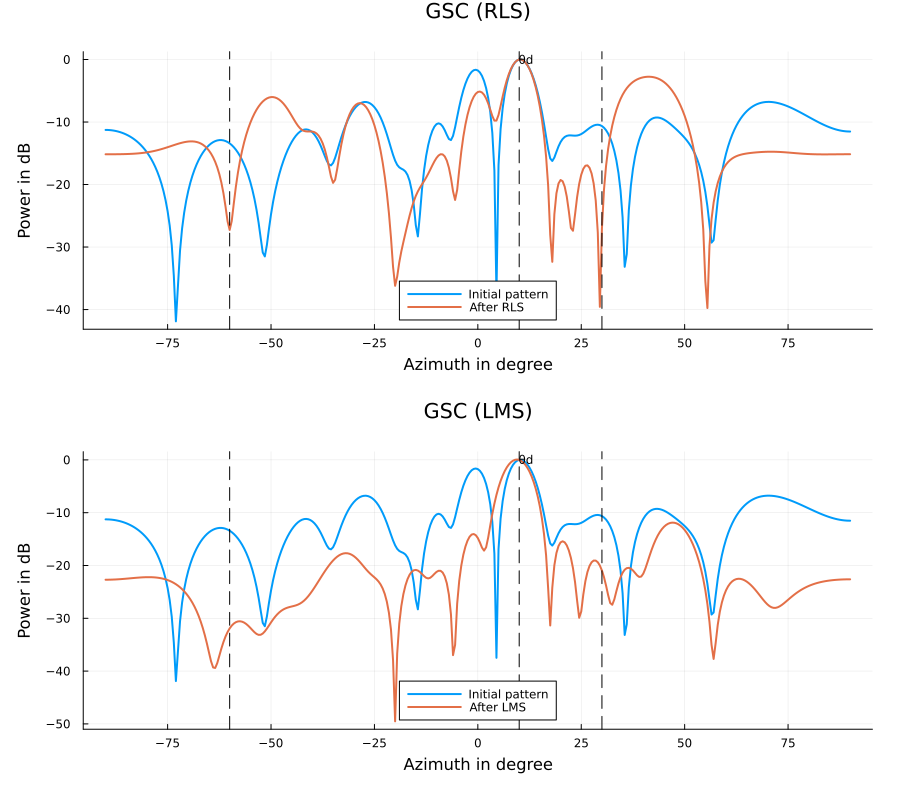

In [3]:
using ArraySignalProcessing
using LinearAlgebra
using Random
using Plots
import Measures

function beampattern_dB(w, pa, ϕ, fc; floor_dB = -60.0)
    A = steer(pa, deg2rad.(ϕ), fc)        # NxL, columns are steering vectors
    resp = vec(w' * A)                    # 1xL -> L
    p = 20 .* log10.(abs.(resp))          # magnitude in dB
    clamp.(p, floor_dB, Inf)              # avoid -Inf for plotting
end


fc = 150e6                         # 150 MHz  -> λ = 2 m
Nelm = 16
ypos = collect(-(Nelm-1)/2 : (Nelm-1)/2) * 1.0   # 1 m spacing (λ/2 at 150 MHz)
pa = IsotropicArray([zeros(Nelm)'; ypos'])       # 2xN: x=0, y=positions

θd = 10.0                           # desired look direction (deg)
Θi = [-60.0, 30.0]                 # two interferers (deg)
Θall = [θd; Θi...]                 # for data generation

d_train = 1                        # just the desired for "training" covariance
d_all   = length(Θall)
Ntrain  = 2000
Nblock  = Int(1e4)
SNRdB   = 10                       # per-source SNR used by unconditional_signals

# ------------------------------------------------------------
# "Training" covariance for initial GSC (desired + noise only)
# ------------------------------------------------------------
Rss_train = I(d_train)
Xtrain = unconditional_signals(pa, Rss_train, Ntrain, SNRdB, deg2rad.([θd]), fc)
Rxx_train = Xtrain * Xtrain' / Ntrain

# LCMV-based GSC decomposition: WQ, B, and an initial WA
C = steer(pa, deg2rad.([θd]), fc)        # Nx1 constraint (distortionless)
G = ones(1, 1)                           # unity gain in look direction
WQ, B, WA0 = lcmv_gsc(Rxx_train, C, G)   # your helper from above

# ------------------------------------------------------------
# Instantiate two GSCs: RLS and LMS (same initial WA)
# ------------------------------------------------------------
K = size(B, 2)                           # #aux channels
λ = 0.995                                # RLS forgetting factor
P0 = Matrix{ComplexF64}(1_000.0 * I(K))  # initial inverse corr estimate
gsc_rls = GeneralizedSidelobeCanceler(RLS(λ, copy(P0)), copy(WQ), copy(WA0), B)

μ_lms = 0.005                          # LMS step size (tune as needed)
gsc_lms = GeneralizedSidelobeCanceler(ArraySignalProcessing.LMS(μ_lms), copy(WQ), copy(WA0), B)

# ------------------------------------------------------------
# Beampattern before adaptation
# ------------------------------------------------------------
ϕaxis = collect(-90.0:0.5:90.0)
w_adapt0 = WQ-B * WA0                      # Nx1
P0_dB = beampattern_dB(vec(w_adapt0), pa, ϕaxis, fc)

# ------------------------------------------------------------
# Generate data block with desired + interferers + noise
# ------------------------------------------------------------
Rss_all = I(d_all)
X = unconditional_signals(pa, Rss_all, Nblock, SNRdB, deg2rad.(Θall), fc)

# ------------------------------------------------------------
# Run adaptation (RLS and LMS) on the same data
# ------------------------------------------------------------
_ = [process!(gsc_rls, col) for col in eachcol(X[:, 1:2000])]
_ = [process!(gsc_lms, col) for col in eachcol(X)]

# weights AFTER adaptation
w_rls = gsc_rls.WQ -B * gsc_rls.WA
w_lms = gsc_lms.WQ -B * gsc_lms.WA

Prls_dB = beampattern_dB(vec(w_rls), pa, ϕaxis, fc)
Plms_dB = beampattern_dB(vec(w_lms), pa, ϕaxis, fc)

# ------------------------------------------------------------
# Plot (two panels): initial vs final beampatterns
# ------------------------------------------------------------
vline_positions = [θd; Θi]  # for markers

p1 = plot(ϕaxis, P0_dB, lw=2, label="Initial pattern",
    title = "GSC (RLS)",
    xlabel = "Azimuth in degree", ylabel = "Power in dB",
    margin = 5*Measures.mm, legend = :bottom)
plot!(ϕaxis, Prls_dB, lw=2, label="After RLS")
for ang in vline_positions
    vline!([ang], lc=:black, ls=:dash, label=false)
end
annotate!([(θd, maximum(Prls_dB), text("θd", :left, 8))])

p2 = plot(ϕaxis, P0_dB, lw=2, label="Initial pattern",
    title = "GSC (LMS)",
    xlabel = "Azimuth in degree", ylabel = "Power in dB",
    margin = 5*Measures.mm, legend = :bottom)
plot!(ϕaxis, Plms_dB, lw=2, label="After LMS")
for ang in vline_positions
    vline!([ang], lc=:black, ls=:dash, label=false)
end
annotate!([(θd, maximum(Plms_dB), text("θd", :left, 8))])

plot(p1, p2, layout=(2,1), size=(900, 800))

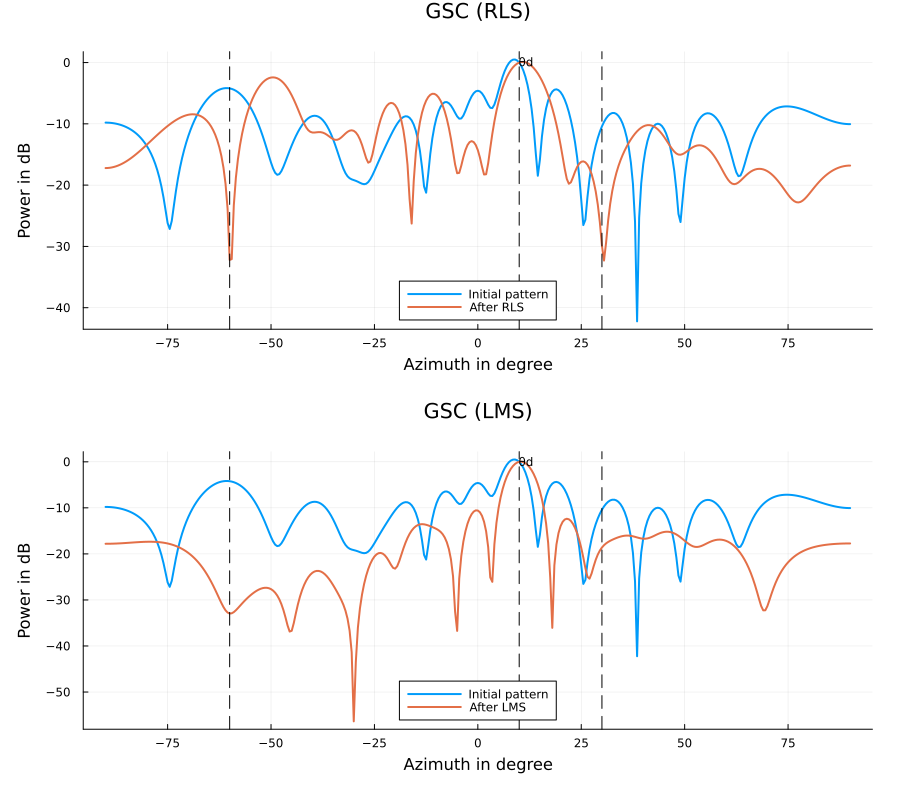

In [5]:
using ArraySignalProcessing
using LinearAlgebra
using Random
using Plots
import Measures
using CUDA

function beampattern_dB(w, pa, ϕ, fc; floor_dB = -60.0)
    A = steer(pa, deg2rad.(ϕ), fc)        # NxL, columns are steering vectors
    resp = w' * A            # 1xL
    resp = cu(transpose(Array(resp)))
    p = 20 .* log10.(abs.(resp)) # magnitude in dB
    clamp.(p, floor_dB, Inf)              # avoid -Inf for plotting
end


fc = 150e6                         # 150 MHz  -> λ = 2 m
Nelm = 16
ypos = collect(-(Nelm-1)/2 : (Nelm-1)/2) * 1.0   # 1 m spacing (λ/2 at 150 MHz)
pa = IsotropicArray(cu([zeros(Nelm)'; ypos']))       # 2xN: x=0, y=positions

θd = 10.0                           # desired look direction (deg)
Θi = cu([-60.0, 30.0])                 # two interferers (deg)
Θall = cu([θd; Array(Θi)...])                 # for data generation

d_train = 1                        # just the desired for "training" covariance
d_all   = length(Θall)
Ntrain  = 2000
Nblock  = Int(1e4)
SNRdB   = 10                       # per-source SNR used by unconditional_signals

# ------------------------------------------------------------
# "Training" covariance for initial GSC (desired + noise only)
# ------------------------------------------------------------
Rss_train = I(d_train)
Xtrain = unconditional_signals(pa, cu(Rss_train), Ntrain, SNRdB, cu(deg2rad.([θd])), fc)
Rxx_train = Xtrain * Xtrain' / Ntrain

# LCMV-based GSC decomposition: WQ, B, and an initial WA
C = steer(pa, cu(deg2rad.([θd])), fc)        # Nx1 constraint (distortionless)
G = cu(ones(1, 1))                           # unity gain in look direction
WQ, B, WA0 = lcmv_gsc(Array(Rxx_train), Array(C), Array(G))   # your helper from above
WQ = cu(WQ)
B = cu(B)
WA0 = cu(WA0)
# ------------------------------------------------------------
# Instantiate two GSCs: RLS and LMS (same initial WA)
# ------------------------------------------------------------
K = size(B, 2)                           # #aux channels
λ = 0.995                                # RLS forgetting factor
P0 = cu(Matrix{ComplexF64}(1_000.0 * I(K)))  # initial inverse corr estimate
gsc_rls = GeneralizedSidelobeCanceler(RLS(λ, copy(P0)), copy(WQ), copy(WA0), B)

μ_lms = 0.005                          # LMS step size (tune as needed)
gsc_lms = GeneralizedSidelobeCanceler(ArraySignalProcessing.LMS(μ_lms), copy(WQ), copy(WA0), B)

# ------------------------------------------------------------
# Beampattern before adaptation
# ------------------------------------------------------------
ϕaxis = cu(collect(-90.0:0.5:90.0))
w_adapt0 = WQ-B * WA0                      # Nx1
P0_dB = beampattern_dB(vec(w_adapt0), pa, ϕaxis, fc)

# ------------------------------------------------------------
# Generate data block with desired + interferers + noise
# ------------------------------------------------------------
Rss_all = I(d_all)
X = unconditional_signals(pa, cu(Rss_all), Nblock, SNRdB, cu(deg2rad.(Θall)), fc)

# ------------------------------------------------------------
# Run adaptation (RLS and LMS) on the same data
# ------------------------------------------------------------
_ = [process!(gsc_rls, col) for col in eachcol(X[:, 1:2000])]
_ = [process!(gsc_lms, col) for col in eachcol(X)]

# weights AFTER adaptation
w_rls = gsc_rls.WQ -B * gsc_rls.WA
w_lms = gsc_lms.WQ -B * gsc_lms.WA

Prls_dB = beampattern_dB(vec(w_rls), pa, ϕaxis, fc)
Plms_dB = beampattern_dB(vec(w_lms), pa, ϕaxis, fc)

# ------------------------------------------------------------
# Plot (two panels): initial vs final beampatterns
# ------------------------------------------------------------
vline_positions = Array([θd; Θi])  # for markers

p1 = plot(Array(ϕaxis), Array(P0_dB), lw=2, label="Initial pattern",
    title = "GSC (RLS)",
    xlabel = "Azimuth in degree", ylabel = "Power in dB",
    margin = 5*Measures.mm, legend = :bottom)
plot!(Array(ϕaxis), Array(Prls_dB), lw=2, label="After RLS")
for ang in vline_positions
    vline!([ang], lc=:black, ls=:dash, label=false)
end
annotate!([(θd, maximum(Prls_dB), text("θd", :left, 8))])

p2 = plot(Array(ϕaxis), Array(P0_dB), lw=2, label="Initial pattern",
    title = "GSC (LMS)",
    xlabel = "Azimuth in degree", ylabel = "Power in dB",
    margin = 5*Measures.mm, legend = :bottom)
plot!(Array(ϕaxis), Array(Plms_dB), lw=2, label="After LMS")
for ang in vline_positions
    vline!([ang], lc=:black, ls=:dash, label=false)
end
annotate!([(θd, maximum(Plms_dB), text("θd", :left, 8))])

plot(p1, p2, layout=(2,1), size=(900, 800))